In [1]:
import os
import sys
from matplotlib.collections import LineCollection
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import (
    LineString,
    MultiLineString,
    MultiPoint,
    MultiPolygon,
    Point,
    Polygon,
)

import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils import GridIntersect
from pulp import *
from collections import Counter

import Supporting_Functions as sf

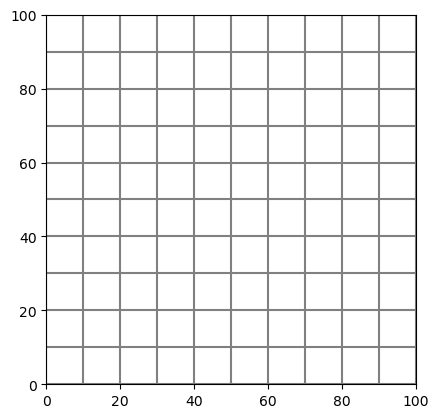

In [2]:
# from the flowpy example https://flopy.readthedocs.io/en/3.6.0/Notebooks/grid_intersection_example.html
delc = 10 * np.ones(10, dtype=float)
delr = 10 * np.ones(10, dtype=float)
xoff = 0.0
yoff = 0.0
angrot = 0.0
sgr = fgrid.StructuredGrid(
    delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot
)
sgr.plot()

In [3]:
p = Polygon(
    shell=[
        (15, 15),
        (20, 50),
        (35, 80.0),
        (80, 50),
        (80, 40),
        (40, 5),
        (15, 12),
    ],
    holes=[[(25, 25), (25, 45), (45, 45), (45, 25)]],
)
ix = GridIntersect(sgr, method="vertex")


In [4]:
ls1 = LineString([(95, 105), (30, 50)])
ls2 = LineString([(30, 50), (90, 22)])
ls3 = LineString([(90, 22), (0, 0)])

# alternet test case
# ls1 = LineString([(6, 0), (6, 98)])
# ls2 = LineString([(6, 98), (75, 1)])
# ls3 = LineString([(75, 1), (90, 80)])
mls = MultiLineString(lines=[ls1, ls2, ls3])

result = ix.intersect(mls)

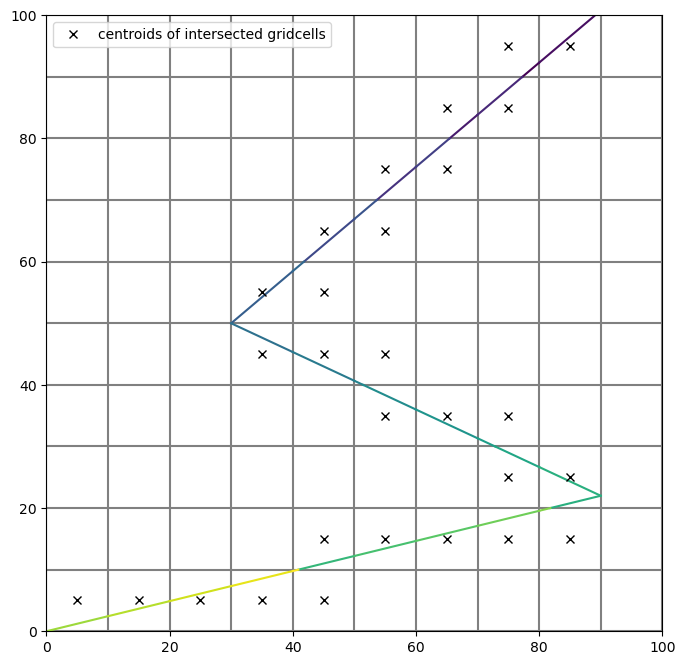

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_linestring(result, ax=ax, cmap="viridis")

for irow, icol in result.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best")

In [6]:
print(result)

[((0, 7), <LINESTRING (80 92.308, 77.273 90)>,  3.57259854)
 ((0, 8), <LINESTRING (89.091 100, 80 92.308)>, 11.90866179)
 ((1, 6), <LINESTRING (70 83.846, 65.455 80)>,  5.9543309 )
 ((1, 7), <LINESTRING (77.273 90, 70 83.846)>,  9.52692944)
 ((2, 5), <LINESTRING (60 75.385, 53.636 70)>,  8.33606326)
 ((2, 6), <LINESTRING (65.455 80, 60 75.385)>,  7.14519708)
 ((3, 4), <LINESTRING (50 66.923, 41.818 60)>, 10.71779561)
 ((3, 5), <LINESTRING (53.636 70, 50 66.923)>,  4.76346472)
 ((4, 3), <LINESTRING (40 58.462, 30 50)>, 13.09952797)
 ((4, 4), <LINESTRING (41.818 60, 40 58.462)>,  2.38173236)
 ((5, 3), <LINESTRING (30 50, 40 45.333)>, 11.0352969 )
 ((5, 4), <LINESTRING (40 45.333, 50 40.667)>, 11.0352969 )
 ((5, 5), <LINESTRING (50 40.667, 51.429 40)>,  1.57647099)
 ((6, 5), <LINESTRING (51.429 40, 60 36)>,  9.45882592)
 ((6, 6), <LINESTRING (60 36, 70 31.333)>, 11.0352969 )
 ((6, 7), <LINESTRING (70 31.333, 72.857 30)>,  3.15294197)
 ((7, 7), <LINESTRING (72.857 30, 80 26.667)>,  7.88235

In [7]:
# Collect information about the intersect to make a cell class and start the ILP

# Get start and end cell each line has a start and end point. The start and end cell will have one unique point each.
points = []
# Get all the points and put them in a list
for val in result:
    lines = val[1]
    points.append(lines.boundary.geoms[0])
    points.append(lines.boundary.geoms[1])
    
# returns a sorted list of lists with the most common items first
counted_points = Counter(points).most_common()
print(counted_points)
# check we have the correct number of start and end cells
assert counted_points[-1][1] == 1, 'No start point or end point found'
assert counted_points[-2][1] == 1, 'Only one start point or end point found'
assert counted_points[-3][1] != 1, 'Three or more start point or end point found'
start_end_points = [counted_points[-1][0], counted_points[-2][0]]
start_end_points

[(<POINT (80 92.308)>, 2), (<POINT (77.273 90)>, 2), (<POINT (70 83.846)>, 2), (<POINT (65.455 80)>, 2), (<POINT (60 75.385)>, 2), (<POINT (53.636 70)>, 2), (<POINT (50 66.923)>, 2), (<POINT (41.818 60)>, 2), (<POINT (40 58.462)>, 2), (<POINT (30 50)>, 2), (<POINT (40 45.333)>, 2), (<POINT (50 40.667)>, 2), (<POINT (51.429 40)>, 2), (<POINT (60 36)>, 2), (<POINT (70 31.333)>, 2), (<POINT (72.857 30)>, 2), (<POINT (80 26.667)>, 2), (<POINT (81.818 20)>, 2), (<POINT (50 12.222)>, 2), (<POINT (40.909 10)>, 2), (<POINT (60 14.667)>, 2), (<POINT (70 17.111)>, 2), (<POINT (80 19.556)>, 2), (<POINT (10 2.444)>, 2), (<POINT (20 4.889)>, 2), (<POINT (30 7.333)>, 2), (<POINT (40 9.778)>, 2), (<POINT (89.091 100)>, 1), (<POINT (0 0)>, 1)]


[<POINT (0 0)>, <POINT (89.091 100)>]

In [8]:
cells = {}
# make a dict of cell objects for every cell that the HFB crosses
for val in result:
    start_or_end_cell = False
    cell_id = tuple([val[0][0],  val[0][1]])
    x_center = val[1].centroid.coords.xy[0]
    y_center = val[1].centroid.coords.xy[1]
    # check if its the start or end cell
    if val[1].boundary.geoms[0] in start_end_points:
        start_or_end_cell = True
    elif val[1].boundary.geoms[1] in start_end_points:
        start_or_end_cell = True
    new_cell = sf.cell(cell_id, x_center, y_center, sgr, start_or_end_cell)
    cells[new_cell.cell_id] = new_cell
len(cells)

28

In [9]:
# Initialize some variables
edges_per_cell = 4 # since each cell is a square
desc_vars = {}
dist_coefs = {}

# Note about the below comment. This is currently being implemented until I find a better way to ban cycles.
# two options include lazy constraints, ie detecting cycles automatically constraining that particular cycle and then returning the ILP
# or much better look into the input output flow idea and implement that. 

# There are two opposing issues 1 we need to force enough cells to have an active edge that the algorithm doesn’t just make boxes.
# But if we have a cell with 5 or more neighbors it forces it to make a box if every cell has to have an active edge.
# This number is an educated guess that seems to work. The other option is to write constraints that prevent boxes as loops. This behavior is already constrained such that there can't be
# 4 active edges on one cell and there can't be three active edges on one cell with an opposing edge active from a neighboring cell.
# There can still be loops where 4 neighboring cells all have one active edge each or 3 cells can make a box.
# may be the best way to do this is constrained those options but that’s a lot of extra constraints per cell. I worry about performance.
max_neibros = 5

# Start the problem
prob = LpProblem("path_finder", LpMinimize)

# Make a dict for all the decision variables well need and a dict for all of the distance coefficients.
for cell in cells.values():
    desc_vars[cell.cell_id] = [LpVariable(edge, cat = 'Binary') for edge in cell.edges.keys()]
    # np.mean-- since there can be multiple distance coefficient per edge if there are two lines going through a cell, 
    # just take the average value so it’s a one to one relationship
    dist_coefs[cell.cell_id] = [np.mean(val) for val in cell.distance_coefs.values()]

# Make the objective function--this just takes each edge * its distance coefficient and sums up the result
prob += lpSum([[dist_coefs.get(cell_id)[i] * desc_vars.get(cell_id)[i] for i in range(edges_per_cell)] for cell_id in dist_coefs.keys()])

# all_dvs = []
# for dvs in desc_vars.values():
#     for dv in dvs:
#         all_dvs.append(dv)
# equ = lpSum(all_dvs) >= 10
# prob += equ
# Except for the start and end points of the horizontal flow barrier if an edge is used it must be 
# connected to another edge. mathematically that looks like sum(incoming edge) >= edge and sum(outgoing edges) >= edge
# also, we need to prevent loops, like having the top of cell 1_0 active while the bottom of cell 0_0 is also active
for cell in cells.values():
    debug = False
    # Useful for debugging if a particular cell is wonky put the cell id here and check out the constraints.
    if cell.cell_id == False:#'8_1':
        debug = True
    if not cell.start_or_end_cell:
        # Get all the neighboring cells 
        neibros = list(filter(lambda x: sf.is_neighboring(cell, x), cells.values()))
        neibros =[neibro.cell_id for neibro in neibros]
        assert len(neibros) > 0, "No neighboring cells found for cell %s" % cell.cell_id
        
        if len(neibros) < max_neibros:
            equ = lpSum(desc_vars.get(cell.cell_id)) >= 1
            prob += equ
        # No boxes!
        equ =  3 >= lpSum(desc_vars.get(cell.cell_id))
        prob += equ
        box_combo_list = sf.get_box_combos(cell.cell_id, neibros, desc_vars)
        for combo in box_combo_list:
            prob += 3 >= lpSum(combo)
        
        for edge in desc_vars.get(cell.cell_id): # loop through each edge of the cell
                # gives two lists of any edges that connect to either point on the edge
                input_edges, output_edges = sf.get_neighboring_edges(cell.cell_id, edge, neibros, desc_vars)
                # returns the decision variable for an opposing edge on a neighboring cell if one exists
                opposing_edge = sf.get_opposing_edge(cell.cell_id, edge, neibros, desc_vars)
                if debug:
                    print('working with ', edge)
                    print('input', input_edges)
                    print('output', output_edges)
                    print('opposing', opposing_edge)
                if input_edges:
                    # Constraint that if an edge is active there must be an active edge leading into it
                    equ = lpSum(input_edges) >= edge
                    if debug:
                        print('input_equ', equ)
                    prob += equ
                # if there is no way to continue the line there can't be a line there
                else:
                    equ = 0 >= edge
                    prob += equ
                if output_edges:
                    # Constraint that if an edge is active there must be an active edge leading out of it
                    equ = lpSum(output_edges) >= edge
                    if debug:
                        print('outut_equ', equ)
                    prob += equ
                # if there is no way to continue the line there can't be a line there
                else:
                    equ = 0 >= edge
                    prob += equ
                if opposing_edge is not None:
                    # Constraint that if an edge is active that same edge can't be active on another cell
                    equ = edge + opposing_edge <= 1
                    if debug:
                        print('opposing_equ', equ)
                    prob += equ
                if opposing_edge is not None:
                    # Constraint so you can't have 3 sides of a cell active and then a matching side from 
                    # a neighboring cell active to form a box
                    other_edges = list(set(desc_vars.get(cell.cell_id))- set([edge]))
                    equ =  3 >= lpSum(other_edges) + opposing_edge
                    prob += equ
                    if debug:
                        print('other_equ', equ)
    

# Solve the problem and check the status.
prob.solve()  
assert LpStatus[prob.status] == 'Optimal', 'A solution could not be found status is %s' % LpStatus[prob.status]
print("Status:", LpStatus[prob.status])      


Status: Optimal


In [10]:
# Get a list of all active edges
active_edges = []
for v in prob.variables():
    if v.varValue == 1:
        # get cell
        for cell in cells.values():
            edge = cell.get_vers_by_edge(v.name)
            if edge is not None:
                active_edges.append(edge)

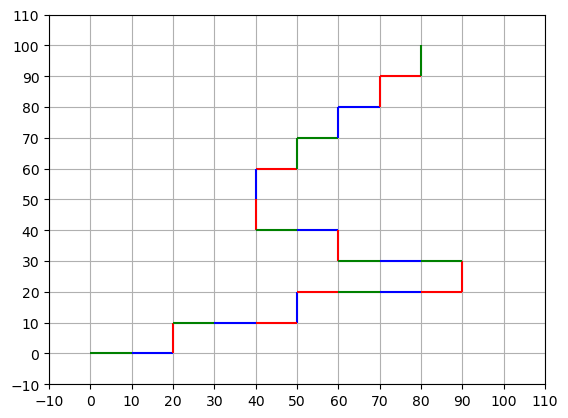

In [11]:
# graph the active edges and see if it worked.
lines = active_edges

lc = LineCollection(lines, colors=['r', 'g', 'b'])
fig = plt.figure()

ax1 = fig.add_subplot(1, 1, 1)
ax1.add_collection(lc)
ax1.autoscale(tight=True)
ax1.set_yticks(ticks=[-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
ax1.set_xticks(ticks=[-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.grid()


plt.show()